In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.1
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
tensorflow 2.0.1
tensorflow_core.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]
print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# 归一化 x = (x - u) / std

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)

In [7]:
# tf.keras.models.Sequential()
model = keras.models.Sequential()
# filters: 卷积核数
# kernel_size: 卷积核的大小
# padding: same  补０使输入和输出的大小一样
# "selu"因为自带规一化，效果更好，可以更快地达到较好的训练效果，就不用自己进行数据规一化了
# SeparableConv2D: 可以减小参数，使计算量减少，使cnn可以用于手机等低端设备，但效率变低了
model.add(keras.layers.Conv2D(filters=8, kernel_size=3,padding='same', activation='relu',input_shape=(28, 28, 1)))
model.add(keras.layers.SeparableConv2D(filters=8, kernel_size=3,padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
# 经过pool之后，数据缩小了pool_size倍，会造成数据损失，为了缓解数据损失，所以下一个卷积参数放大pool_size倍
model.add(keras.layers.SeparableConv2D(filters=16, kernel_size=3,padding='same', activation='relu'))
model.add(keras.layers.SeparableConv2D(filters=16, kernel_size=3,padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.SeparableConv2D(filters=32, kernel_size=3,padding='same', activation='relu'))
model.add(keras.layers.SeparableConv2D(filters=32, kernel_size=3,padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 32)          4

In [6]:
logdir = "./separable-cnn-selu-callbacks"
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True)
]
history = model.fit(x_train_scaled, y_train, epochs=10, validation_data=(x_valid_scaled, y_valid), callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 50s 909us/sample - loss: 0.9045 - accuracy: 0.6759 - val_loss: 0.5245 - val_accuracy: 0.8100
Epoch 2/10
55000/55000 [==============================] - 48s 880us/sample - loss: 0.4683 - accuracy: 0.8293 - val_loss: 0.4314 - val_accuracy: 0.8376
Epoch 3/10
55000/55000 [==============================] - 48s 879us/sample - loss: 0.4001 - accuracy: 0.8534 - val_loss: 0.3681 - val_accuracy: 0.8662
Epoch 4/10
55000/55000 [==============================] - 34s 613us/sample - loss: 0.3637 - accuracy: 0.8664 - val_loss: 0.3554 - val_accuracy: 0.8702
Epoch 5/10
55000/55000 [==============================] - 29s 525us/sample - loss: 0.3402 - accuracy: 0.8753 - val_loss: 0.3418 - val_accuracy: 0.8702
Epoch 6/10
55000/55000 [==============================] - 29s 532us/sample - loss: 0.3224 - accuracy: 0.8823 - val_loss: 0.3289 - val_accuracy: 0.8780
Epoch 7/10
55000/55000 [=====================

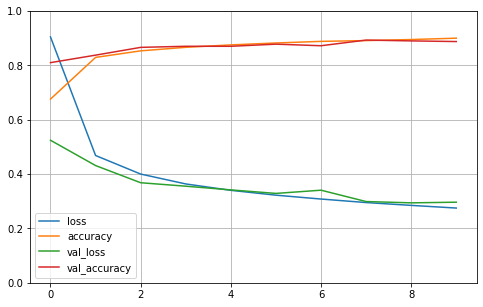

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=[8, 5])
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)


In [ ]:
model.evaluate(x_test_scaled, y_test)